In [1]:
import sys
print(sys.executable)

/usr/local/opt/python@3.11/bin/python3.11


In [2]:
!/usr/local/opt/python@3.11/bin/python3.11 -m pip install scikit-learn


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
import pandas as pd
import sklearn
from pathlib import Path

# Read Data

In [4]:
dataframes_dict = {}
for folder in Path('../consolidated_data_files').iterdir():
    if folder.is_dir():
        parquet_path = folder / 'consolidated.parquet'
        if parquet_path.exists():
            print(f"Reading {folder.name}...")
            df = pd.read_parquet(parquet_path)
            # Store in dictionary with name as key
            dataframes_dict[folder.name] = df
            print(f"Read {folder.name}!")
print("Done!")

Reading uonlp_CulturaX__...
Read uonlp_CulturaX__!
Reading allenai_c4_en...
Read allenai_c4_en!
Reading dolma...
Read dolma!
Reading HuggingFaceFW_fineweb-edu_data__...
Read HuggingFaceFW_fineweb-edu_data__!
Reading tiiuae_falcon-refinedweb_data...
Read tiiuae_falcon-refinedweb_data!
Done!


# Descriptive Stats

In [5]:
for name, df in dataframes_dict.items():
    print(f"{name}:")
    print(f"  Rows: {df.shape[0]}")
    print(f"  Columns: {df.shape[1]}")
    print(f"  Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB\n")

uonlp_CulturaX__:
  Rows: 109879658
  Columns: 2
  Memory usage: 1676.63 MB

allenai_c4_en:
  Rows: 15668873
  Columns: 2
  Memory usage: 239.09 MB

dolma:
  Rows: 331096
  Columns: 2
  Memory usage: 5.05 MB

HuggingFaceFW_fineweb-edu_data__:
  Rows: 12019813
  Columns: 2
  Memory usage: 183.41 MB

tiiuae_falcon-refinedweb_data:
  Rows: 33271341
  Columns: 2
  Memory usage: 507.68 MB



# Histogram

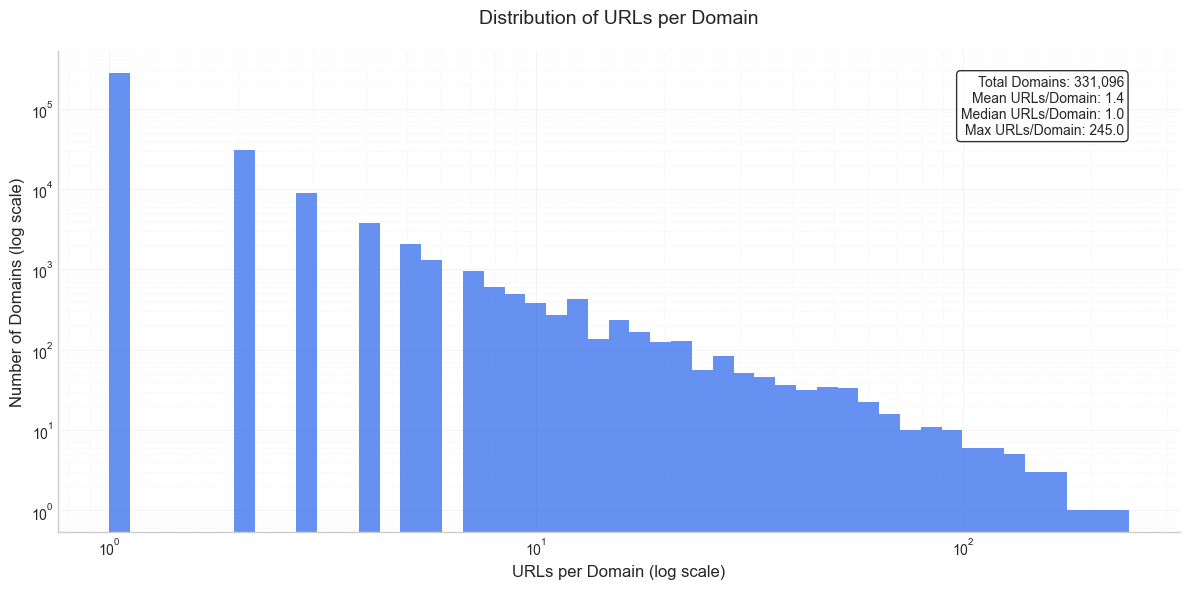

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Get the URL counts per domain
#url_counts = dataframes_dict['uonlp_CulturaX__']['count'].values
url_counts = dataframes_dict['dolma']['count'].values

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

# Create histogram with log-scale bins
bins = np.logspace(np.log10(1), np.log10(url_counts.max()), 50)
ax.hist(url_counts, bins=bins, alpha=0.7, color='#2563eb')

# Set log scale for x-axis
ax.set_xscale('log')
ax.set_yscale('log')  # Also using log scale for y-axis due to long tail

# Customize labels and title
ax.set_xlabel('URLs per Domain (log scale)', fontsize=12)
ax.set_ylabel('Number of Domains (log scale)', fontsize=12)
ax.set_title('Distribution of URLs per Domain', fontsize=14, pad=20)

# Customize grid and spines
ax.grid(True, which='major', linestyle='-', alpha=0.2)
ax.grid(True, which='minor', linestyle=':', alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add some statistics annotations
stats_text = (
    f'Total Domains: {len(url_counts):,}\n'
    f'Mean URLs/Domain: {url_counts.mean():.1f}\n'
    f'Median URLs/Domain: {np.median(url_counts):.1f}\n'
    f'Max URLs/Domain: {url_counts.max():,}'
)
ax.text(0.95, 0.95, stats_text,
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Lorenz Curves


uonlp_CulturaX__:
  Top 1% domains hold 63.8% of URLs
  Top 10% domains hold 89.5% of URLs
  Median URLs per domain: 3.0

allenai_c4_en:
  Top 1% domains hold 43.1% of URLs
  Top 10% domains hold 76.9% of URLs
  Median URLs per domain: 3.0

dolma:
  Top 1% domains hold 12.0% of URLs
  Top 10% domains hold 32.0% of URLs
  Median URLs per domain: 1.0

HuggingFaceFW_fineweb-edu_data__:
  Top 1% domains hold 61.8% of URLs
  Top 10% domains hold 86.7% of URLs
  Median URLs per domain: 9.0

tiiuae_falcon-refinedweb_data:
  Top 1% domains hold 56.2% of URLs
  Top 10% domains hold 85.0% of URLs
  Median URLs per domain: 2.0


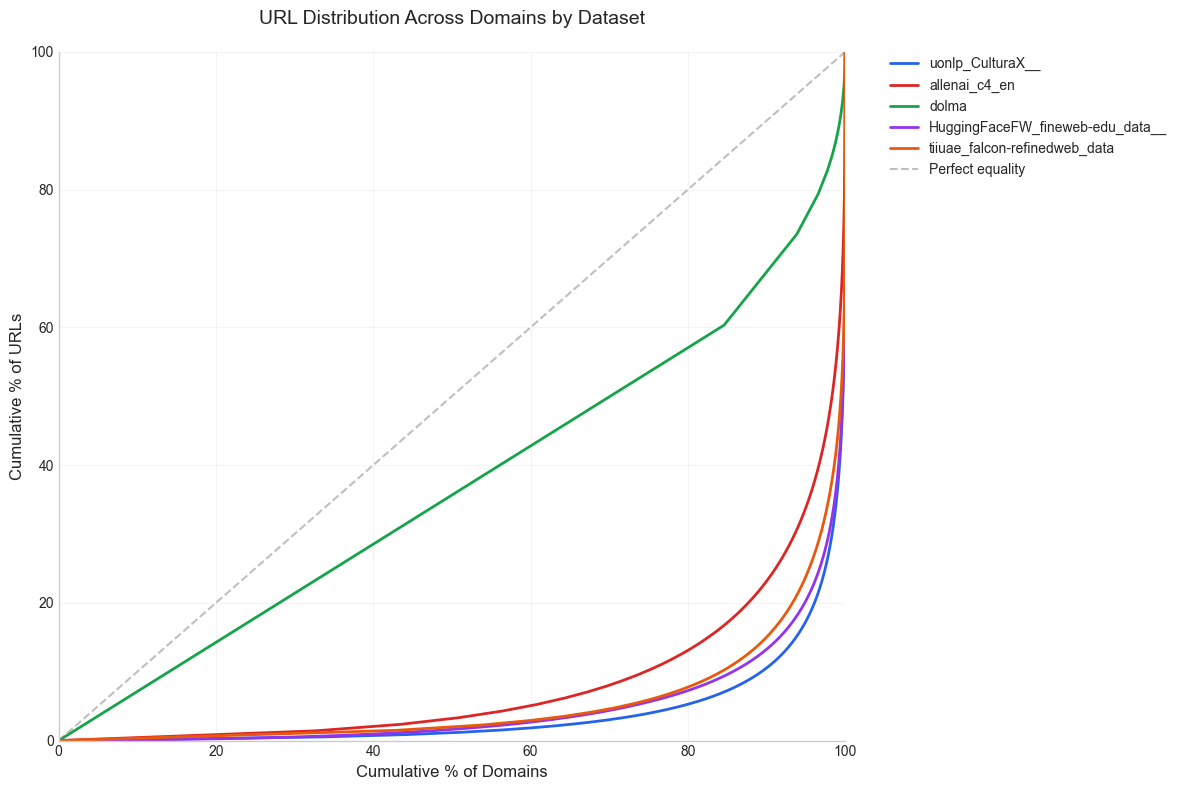

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Plot Lorenz curve for each dataset with different colors
colors = ['#2563eb', '#dc2626', '#16a34a', '#9333ea', '#ea580c', '#0891b2']
for (name, df), color in zip(dataframes_dict.items(), colors):
    # Sort domains by number of URLs
    sorted_counts = np.sort(df['count'].values)
    
    # Calculate cumulative % of URLs
    cumulative_urls = np.cumsum(sorted_counts) / sorted_counts.sum() * 100
    
    # Calculate cumulative % of domains
    cumulative_domains = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts) * 100
    
    # Plot the distribution
    ax.plot(cumulative_domains, cumulative_urls, color=color, linewidth=2, label=name)
    
    # Print statistics for each dataset
    print(f"\n{name}:")
    print(f"  Top 1% domains hold {100 - cumulative_urls[int(0.99 * len(cumulative_urls))]:.1f}% of URLs")
    print(f"  Top 10% domains hold {100 - cumulative_urls[int(0.90 * len(cumulative_urls))]:.1f}% of URLs")
    print(f"  Median URLs per domain: {sorted_counts[len(sorted_counts)//2]:.1f}")

# Add diagonal line representing perfect equality
ax.plot([0, 100], [0, 100], '--', color='gray', alpha=0.5, label='Perfect equality')

# Customize the plot
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xlabel('Cumulative % of Domains', fontsize=12)
ax.set_ylabel('Cumulative % of URLs', fontsize=12)
ax.set_title('URL Distribution Across Domains by Dataset', fontsize=14, pad=20)

# Customize grid and spines
ax.grid(True, which='major', linestyle='-', alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend with smaller font and transparency
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, 
         framealpha=0.8, borderaxespad=0.)

plt.tight_layout()
plt.show()


uonlp_CulturaX__:
  Mean URLs per domain: 65.3
  Median URLs per domain: 3.0

allenai_c4_en:
  Mean URLs per domain: 23.3
  Median URLs per domain: 3.0

dolma:
  Mean URLs per domain: 1.4
  Median URLs per domain: 1.0

HuggingFaceFW_fineweb-edu_data__:
  Mean URLs per domain: 106.4
  Median URLs per domain: 9.0

tiiuae_falcon-refinedweb_data:
  Mean URLs per domain: 29.1
  Median URLs per domain: 2.0


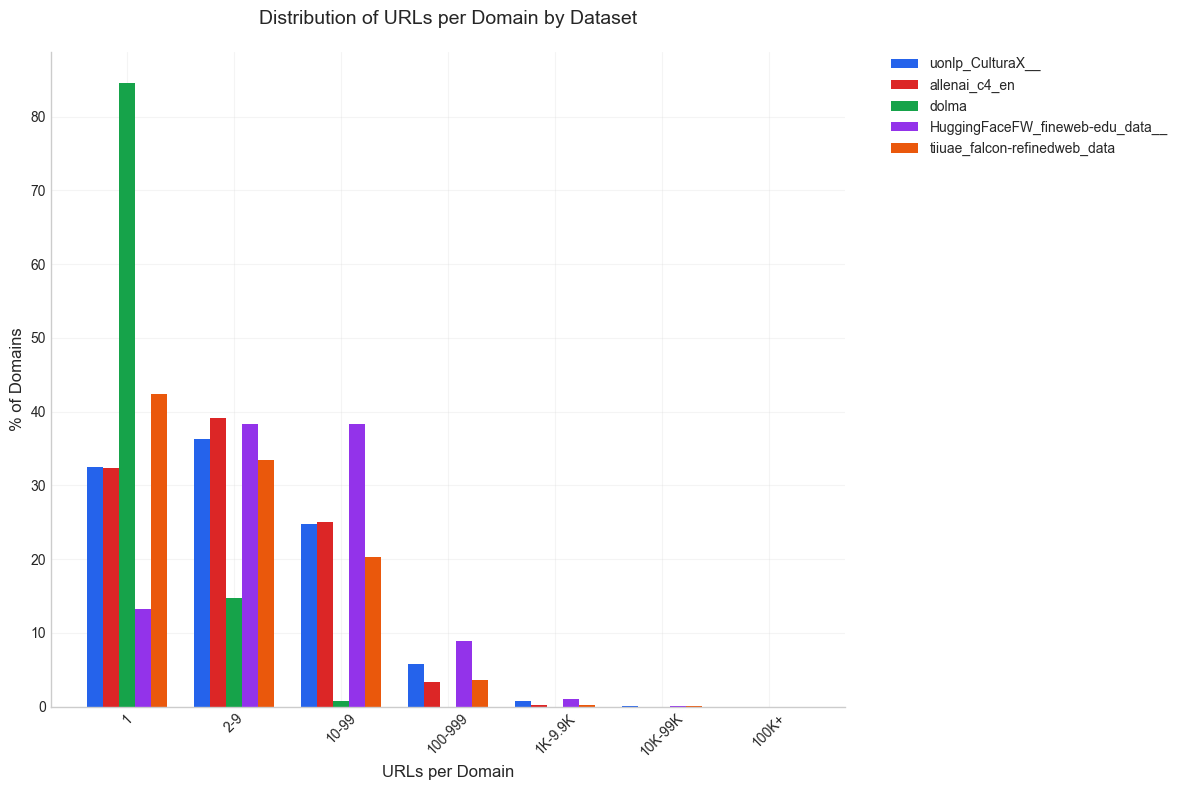

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-v0_8-whitegrid')

# Create the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Define custom buckets and their labels
bucket_edges = [1, 2, 10, 100, 1000, 10000, 100000, 1000000]
bucket_labels = ['1', '2-9', '10-99', '100-999', '1K-9.9K', '10K-99K', '100K+']

# Calculate bar positions
n_datasets = len(dataframes_dict)
n_buckets = len(bucket_labels)
bar_width = 0.15  # Width of each bar
group_positions = np.arange(n_buckets)  # Center positions for each group

colors = ['#2563eb', '#dc2626', '#16a34a', '#9333ea', '#ea580c', '#0891b2']
for i, ((name, df), color) in enumerate(zip(dataframes_dict.items(), colors)):
    bucket_counts = []
    for j in range(len(bucket_edges)-1):
        if j == len(bucket_edges)-2:  # Last bucket includes all higher values
            count = ((df['count'] >= bucket_edges[j])).sum()
        else:
            count = ((df['count'] >= bucket_edges[j]) & 
                    (df['count'] < bucket_edges[j+1])).sum()
        bucket_counts.append(count / len(df) * 100)  # Convert to percentage
    
    # Calculate bar positions
    bar_positions = group_positions + (i - n_datasets/2 + 0.5) * bar_width
    
    # Plot bars
    ax.bar(bar_positions, 
           bucket_counts,
           width=bar_width,
           color=color,
           label=name)
    
    # Print statistics
    print(f"\n{name}:")
    print(f"  Mean URLs per domain: {df['count'].mean():.1f}")
    print(f"  Median URLs per domain: {df['count'].median():.1f}")

# Customize the plot
ax.set_xticks(group_positions)
ax.set_xticklabels(bucket_labels, rotation=45)
ax.set_ylim(0, None)

ax.set_xlabel('URLs per Domain', fontsize=12)
ax.set_ylabel('% of Domains', fontsize=12)
ax.set_title('Distribution of URLs per Domain by Dataset', fontsize=14, pad=20)

# Customize grid and spines
ax.grid(True, which='major', linestyle='-', alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend with smaller font
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, 
         borderaxespad=0.)

plt.tight_layout()
plt.show()

# Cluster

In [9]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

dolma_sample = dataframes_dict['dolma'].sample(10000)

X = dolma_sample[['count']]

# Dictionary to store silhouette scores
silhouette_scores = {}

# Test n_clusters from 3 to 10
for n in range(3, 11):
    clustering = AgglomerativeClustering(n_clusters=n)
    labels = clustering.fit_predict(X)
    dolma_sample[f"cluster_{n}"] = labels
    
    # Calculate silhouette score
    if n > 1:  # Silhouette score requires at least 2 clusters
        score = silhouette_score(X, labels)
        silhouette_scores[n] = score

# Print the DataFrame and silhouette scores
print(dolma_sample.sample(10))
print("Silhouette Scores:", silhouette_scores)

                        domain  count  cluster_3  cluster_4  cluster_5  \
107186           mrguider.info    1.0          0          1          0   
277383    www.pavertraders.com    1.0          0          1          0   
264429     www.mommyfactor.net    1.0          0          1          0   
250047      www.kiprinform.com    1.0          0          1          0   
289345   www.ropesdirect.co.uk    1.0          0          1          0   
104704  mis.atcoindustries.com    1.0          0          1          0   
2270       about.sharecare.com    1.0          0          1          0   
302689   www.stylesglamour.com    1.0          0          1          0   
16257                benyd.com    1.0          0          1          0   
65748      geoffrey-gibson.com    1.0          0          1          0   

        cluster_6  cluster_7  cluster_8  cluster_9  cluster_10  
107186          5          5          5          5           5  
277383          5          5          5          5     

In [10]:
from sklearn.cluster import AgglomerativeClustering

dolma_sample_20k = dataframes_dict['dolma'].sample(20000)

X = dolma_sample_20k[['count']]

# Choose the optimal number of clusters (replace `optimal_n` with your value)
optimal_n = 7

# Run the clustering
clustering = AgglomerativeClustering(n_clusters=optimal_n)
dolma_sample_20k['cluster'] = clustering.fit_predict(X)

# Calculate the range of values within each cluster
cluster_ranges = (
    dolma_sample_20k
    .groupby('cluster')['count']
    .agg(['min', 'max'])
    .rename(columns={'min': 'min_count', 'max': 'max_count'})
)

# Show the results
print("\nCluster Ranges:")
print(cluster_ranges)



Cluster Ranges:
         min_count  max_count
cluster                      
0              5.0       16.0
1              2.0        4.0
2             63.0      110.0
3             18.0       33.0
4            164.0      164.0
5              1.0        1.0
6             37.0       50.0
